**Описание проекта:**

Несколько прошлых месяцев бизнес развлекательного приложения Procrastinate Pro+ постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.



**Описание данных**
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Загрузка данные и подготовка их к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st

In [2]:
#Сформируем датасеты
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


В столбцах "Session Start" и "Session End" нужно изменить тип данных 

In [4]:
#Проверим наличие дубликатов 
visits.duplicated().sum()

0

In [5]:
visits.sample(random_state = None, n = 5)

,User Id,Region,Device,Channel,Session Start,Session End
132166,38192320322,United States,Mac,organic,2019-09-03 16:29:04,2019-09-03 16:31:08
195173,573471957544,United States,Android,TipTop,2019-10-21 19:49:40,2019-10-21 20:16:31
204213,609804618409,United States,iPhone,FaceBoom,2019-10-27 03:42:51,2019-10-27 04:10:55
99972,342095239706,United States,iPhone,FaceBoom,2019-08-07 04:07:02,2019-08-07 05:14:25
216567,821293567219,France,Android,organic,2019-05-20 18:48:36,2019-05-20 19:11:25


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


В столбце "Event Dt" нужно изменить тип данных 

In [7]:
orders.describe()

,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


In [8]:
orders.sample(random_state = None, n = 5)

,User Id,Event Dt,Revenue
15590,481080638156,2019-09-01 13:09:13,4.99
27757,683709245627,2019-10-30 21:24:53,4.99
37017,586630382025,2019-09-30 17:48:43,4.99
4611,832717516617,2019-06-23 13:14:36,4.99
3370,395186914429,2019-06-13 03:21:57,4.99


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В столбце "dt" нужно изменить тип данных

In [10]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


In [11]:
costs.sample(random_state = None, n = 5)

,dt,Channel,costs
1385,2019-09-03,OppleCreativeMedia,8.000
1153,2019-07-13,LeapBob,8.610
447,2019-07-27,RocketSuperAds,9.555
410,2019-06-20,RocketSuperAds,9.360
1280,2019-05-21,OppleCreativeMedia,4.000


In [12]:
#Чтобы часть столбцов в дальнейшем не скрывалась, настроим принудительное отображение
pd.set_option('display.max_columns', None)

In [13]:
#приведем к нижнему регистру названия столбцов
visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)
costs.columns = map(str.lower, costs.columns)

In [14]:
#поменяем названия столбцов
visits.columns.to_list()

['user id', 'region', 'device', 'channel', 'session start', 'session end']

In [15]:
visits.columns = ['user_id', 'region', 'device', 'channel','session_start', 'session_end']

In [16]:
orders.columns.to_list()

['user id', 'event dt', 'revenue']

In [17]:
orders.columns = ['user_id', 'event_dt', 'revenue']

In [18]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [19]:
#Провериим
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Мы открыли датасеты, проверили данные, переименовали столбцы и заменили тип данных в столбцах с указанием времени.

# Функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми мы познакомились в теоретических уроках.

In [20]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

  

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [21]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [22]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [23]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi()

In [24]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [25]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [26]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [27]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функции, необходимые нам для работы написаны. Можно приступать к исследованию.

# Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

## Профили пользователей

Получим профили пользователей.  
Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу

In [28]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


Установим момент и горизонт анализа данных.  
На календаре 1 ноября 2019 года, и зададим горизонт анализа 14 дней, так как по условиям принятая в компании окупаемость считается за 2 недели.

In [29]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
ignore_horizon=False

In [30]:
profiles['dt'] =  pd.to_datetime(profiles['dt']).dt.date
min_analysis_date = profiles['dt'].min()
max_analysis_date =  observation_date - timedelta(days=horizon_days - 1)
print('Минимальная  дата привлечения: {}\n'
     'Максимальная дата привлечения: {}'.format(min_analysis_date, max_analysis_date))



Минимальная  дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-19


## Профили пользователей по странам

Из каких стран приходят посетители?  
Какие страны дают больше всего платящих пользователей?

In [31]:
#Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


In [32]:
profiles.groupby(['region', 'payer']).agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)

,,user_id
region,payer,
United States,False,93100
UK,False,16875
France,False,16787
Germany,False,14365
United States,True,6902
UK,True,700
France,True,663
Germany,True,616


Самая большая доля и количество платящих пользователей из США.  
Платящие пользователи из стран Европы примерно в равных 3.8-4.1%

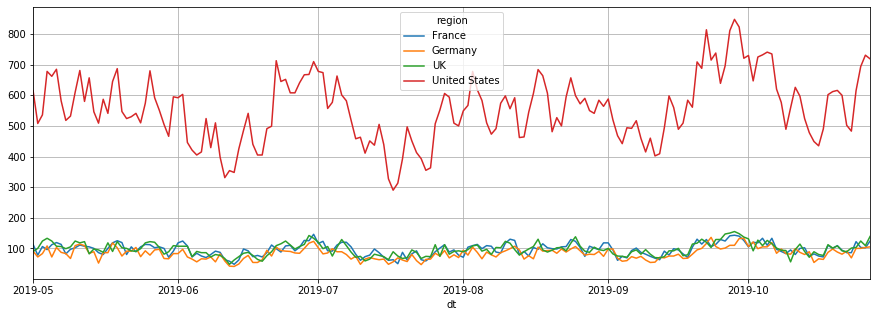

In [33]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='region',  # страна переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

## Профили пользователей по устройствам

Какими устройствами они пользуются?  
С каких устройств чаще всего заходят платящие пользователи?

In [34]:
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


In [35]:
profiles.groupby(['device', 'payer']).agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)

,,user_id
device,payer,
iPhone,False,51097
Android,False,32982
PC,False,28918
Mac,False,28130
iPhone,True,3382
Android,True,2050
Mac,True,1912
PC,True,1537


 Платящие пользователи предпочитают яблочные устройства: у Mac самая боьшая доля - 6.36%.  
 В количественном выражении больше всего платящих пользователей среди владельцев iPhone.  
 Самая маленькая доля 5% и количество платящих пользователей среди владельцев PC.

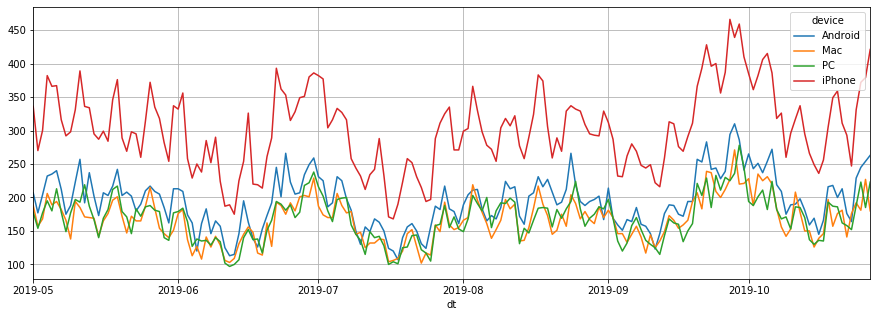

In [36]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='device',  # устройство
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

## Профили пользователей по каналам

По каким рекламным каналам шло привлечение пользователей?  
Какие каналы приносят больше всего платящих пользователей?

In [37]:
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


In [38]:
profiles.groupby(['channel', 'payer']).agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)

,,user_id
channel,payer,
organic,False,55279
FaceBoom,False,25587
TipTop,False,17683
OppleCreativeMedia,False,8372
LeapBob,False,8291
WahooNetBanner,False,8100
MediaTornado,False,4208
YRabbit,False,4147
RocketSuperAds,False,4096


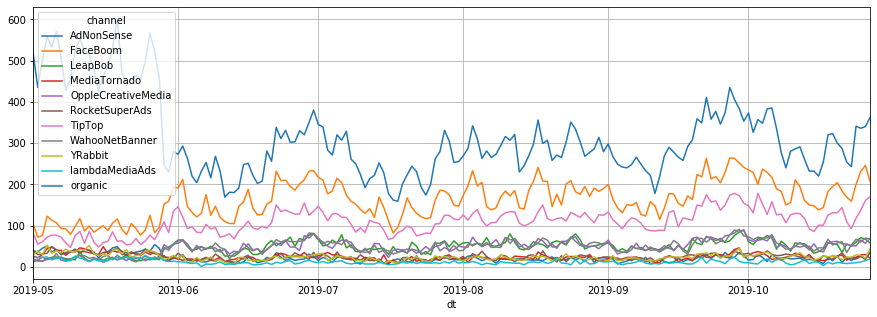

In [39]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # канал
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

Самую большую долю 11% и количество платящих пользователей мы получили с канала FaceBoom.  
Меньше всего доля платящих с канала organic - 2%

## Выводы 

Самая большая доля и количество платящих пользователей из США.
Платящие пользователи из стран Европы примерно в равных 3.8-4.1%

Платящие пользователи предпочитают яблочные устройства: у Mac самая боьшая доля - 6.36%.
В количественном выражении больше всего платящих пользователей среди владельцев iPhone.
Самая маленькая доля 5% и количество платящих пользователей среди владельцев PC.

Самую большую долю 11% и количество платящих пользователей мы получили с канала FaceBoom.
Меньше всего доля платящих с канала organic - 2%

# Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Необходимо очистить данные от органических пользователей, чтобы они не мешали анализу эффективности платной рекламы.

In [40]:
# перезапишем датасет, удалим орггаников
profiles = profiles.query('channel != "organic"')
# проверим
profiles['channel'].unique()

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [41]:
#Посчитаем сколько всего потрачено денег на привлечение пользователей
cac_total = profiles['acquisition_cost'].sum()
cac_total.round(2)

105497.3

In [42]:
#Посчитаем сколько потрачено денег на привлечение пользователей по источникам
#суммарно и на одного пользователя CAC
fdg=profiles.groupby('channel').agg({'acquisition_cost': ['sum', 'mean']}).rename(columns={'sum':'sum_cost', 'mean':'mean_cost'}).reset_index()
fdg.sort_values(by = 'channel')


channel acquisition_cost          
                              sum_cost mean_cost
0          AdNonSense          3911.25  1.008054
1            FaceBoom         32445.60  1.113286
2             LeapBob          1797.60  0.210172
3        MediaTornado           954.48  0.218717
4  OppleCreativeMedia          2151.25  0.250000
5      RocketSuperAds          1833.00  0.412095
6              TipTop         54751.30  2.799003
7      WahooNetBanner          5151.00  0.602245
8             YRabbit           944.22  0.218975
9      lambdaMediaAds          1557.60  0.724802

In [60]:
#Посчитаем сколько потрачено денег на привлечение пользователей по источникам
#суммарно и на одного пользователя CAC
fdg_rev=profiles.groupby('channel').agg({'acquisition_cost': ['sum', 'mean']}).rename(columns={'sum':'sum_cost', 'mean':'mean_cost'}).reset_index()
fdg_rev.columns = ['channel', 'sum_cost','mean_cost']
fdg_rev.sort_values('sum_cost', ascending=False)

,channel,sum_cost,mean_cost
6,TipTop,54751.30,2.799003
1,FaceBoom,32445.60,1.113286
7,WahooNetBanner,5151.00,0.602245
0,AdNonSense,3911.25,1.008054
4,OppleCreativeMedia,2151.25,0.250000
5,RocketSuperAds,1833.00,0.412095
2,LeapBob,1797.60,0.210172
9,lambdaMediaAds,1557.60,0.724802
3,MediaTornado,954.48,0.218717
8,YRabbit,944.22,0.218975


In [43]:
fdg=profiles.groupby('dt').agg({'acquisition_cost': ['sum', 'mean']}).rename(columns={'sum':'sum_cost', 'mean':'mean_cost'}).reset_index()
fdg

dt acquisition_cost          
                        sum_cost mean_cost
0    2019-05-01          304.820  0.781590
1    2019-05-02          230.845  0.714690
2    2019-05-03          263.070  0.760318
3    2019-05-04          337.000  0.737418
4    2019-05-05          319.905  0.730377
..          ...              ...       ...
175  2019-10-23          592.995  1.195554
176  2019-10-24          737.590  1.231369
177  2019-10-25          862.600  1.259270
178  2019-10-26          952.370  1.350879
179  2019-10-27          967.165  1.334021

[180 rows x 3 columns]

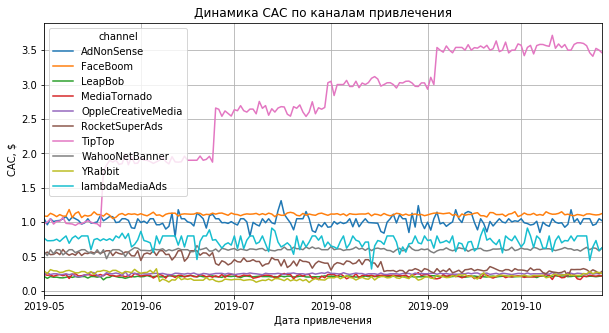

In [44]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show() 

Дороже всего обошлись пользовтели с каналов TipTop, FaceBoom и AdNonSense.  
Дешевле всего - LeapBob, MediaTornado и YRabbit.

In [45]:
profiles['acquisition_cost'].mean()

1.1274813239427588

**Вывод**  
Всего было потрачено 105497.3 долларов.  
Средняя стоимость привлечения пользователя по проекту составляет 1.13 ($).  
Самыми дорогими были пользователи из TipTop 2.8, FaceBoom 1.11 и AdNonSense 1.  
Дешевле всего обошлись пользователи из LeapBob, YRabbit и MediaTornado (примерно по 20 центов)

# Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишем проблемы, которые мы обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела.  
При решении этого шага считем, что вы смотрите данные 1-го ноября 2019 года и что в нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

## Анализ общей окупаемость рекламы

Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

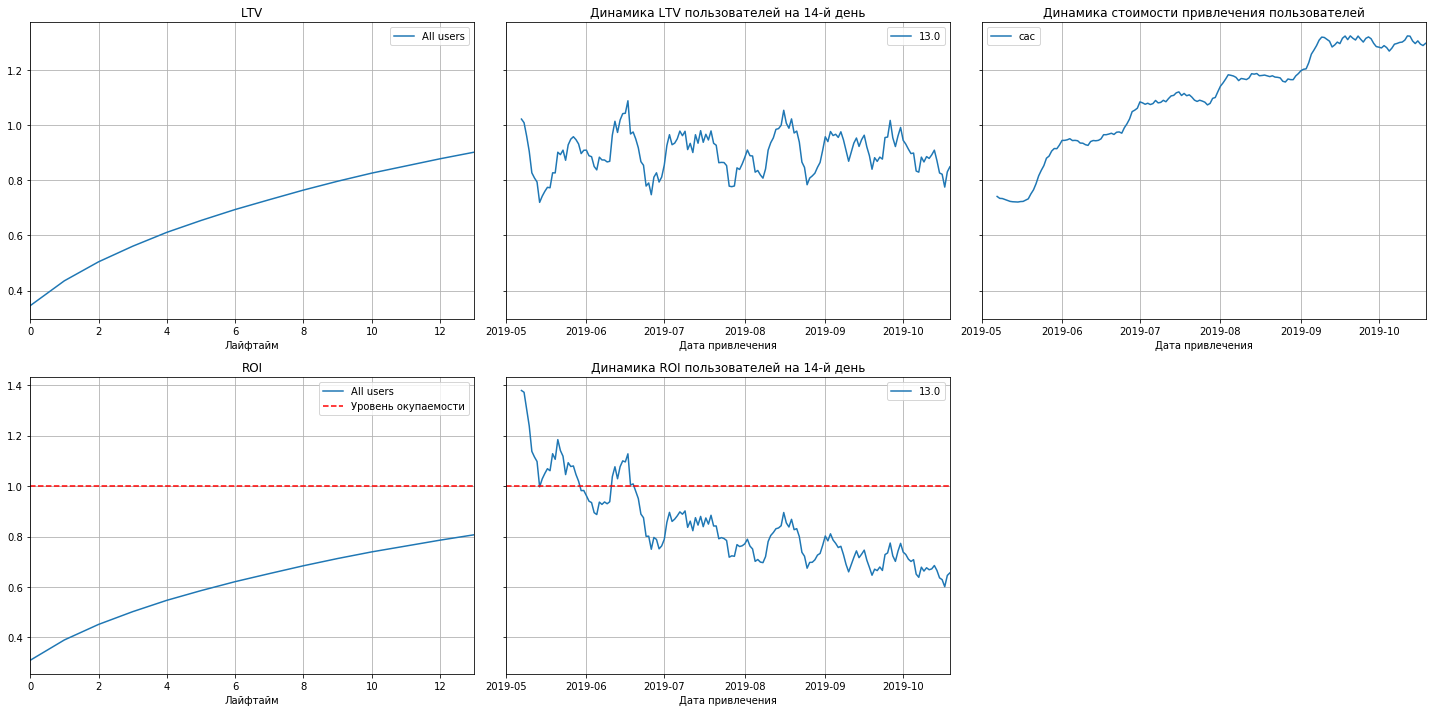

In [46]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков видно, что ROI не достигает уровня 1, а значит реклама в целом не окупается.  
С каждым новым месяцем пользователи обходились всё дороже и дороже.  
Необходимо выяснить причину

## Анализ окупаемости рекламы с разбивкой по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

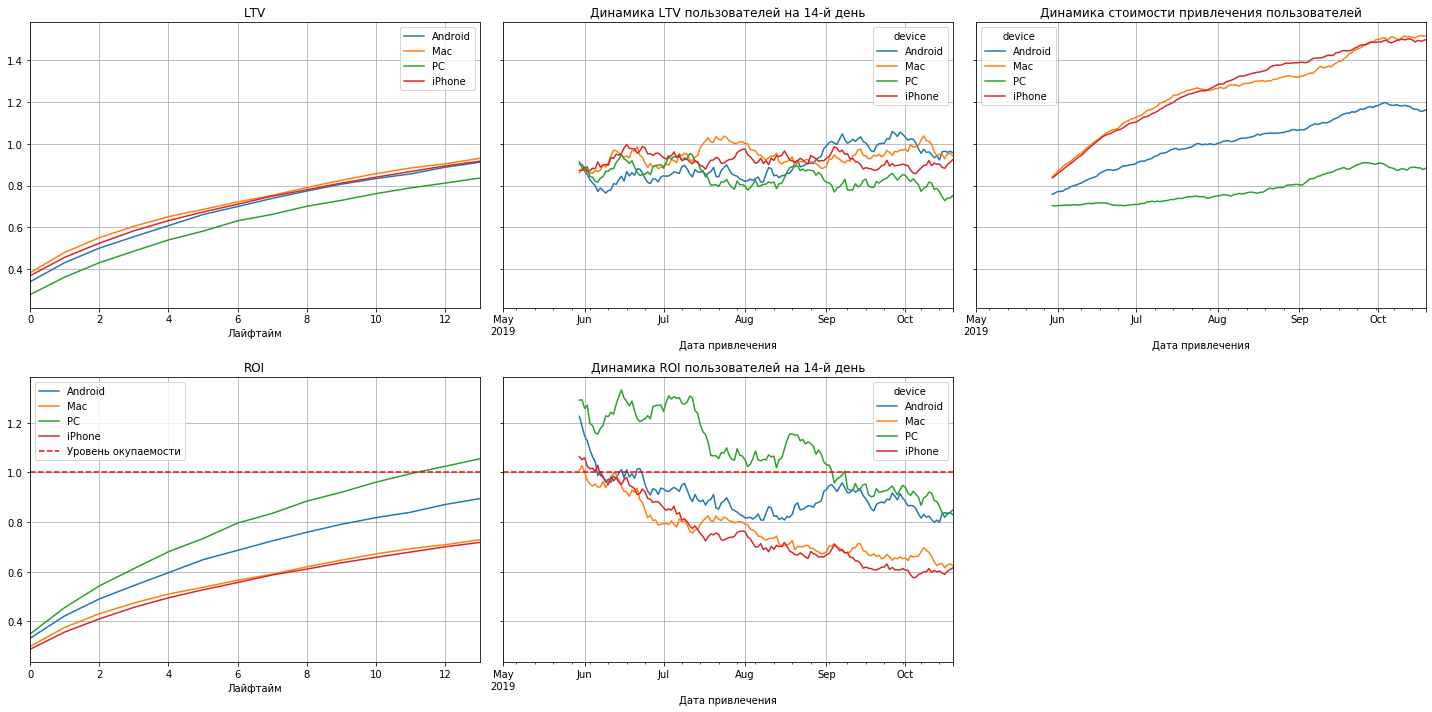

In [47]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
) 

Если рассматривать 14 дневный Лайфтайм, то самыми доходными для нас являются пользователи MAC м IPhone, их LTV выше остальных.  Самый низкий уровень показывают пользователи PC.  
Если же смотреть в динамике, то стоимость привлечения тановится всё выше и выше для всех, но у яблочников рост наиболее выражен.
Также стоит отметить, что в сентябре был пик роста LTV у Android.  

Положительный ROI (>1), а значит и окупаемость показывают только пользователи PC и то только к 11 дню жизни. Да и они перестали окупаться начиная с сентября. Последние месяцы все источники убыточны.  

Пользователи MAC IPhone, не смотря на свои покупки и высокий LTV не окупают затраты на привлекающую их рекламу, поэтому показывают отрицательный ROI <1.  


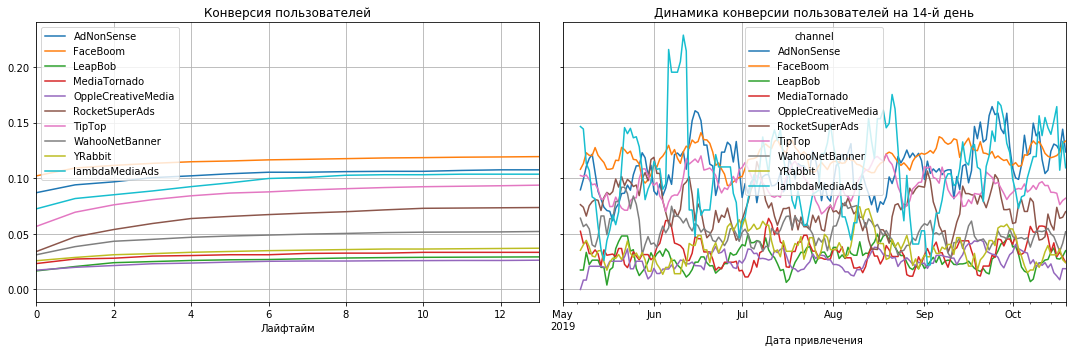

In [61]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

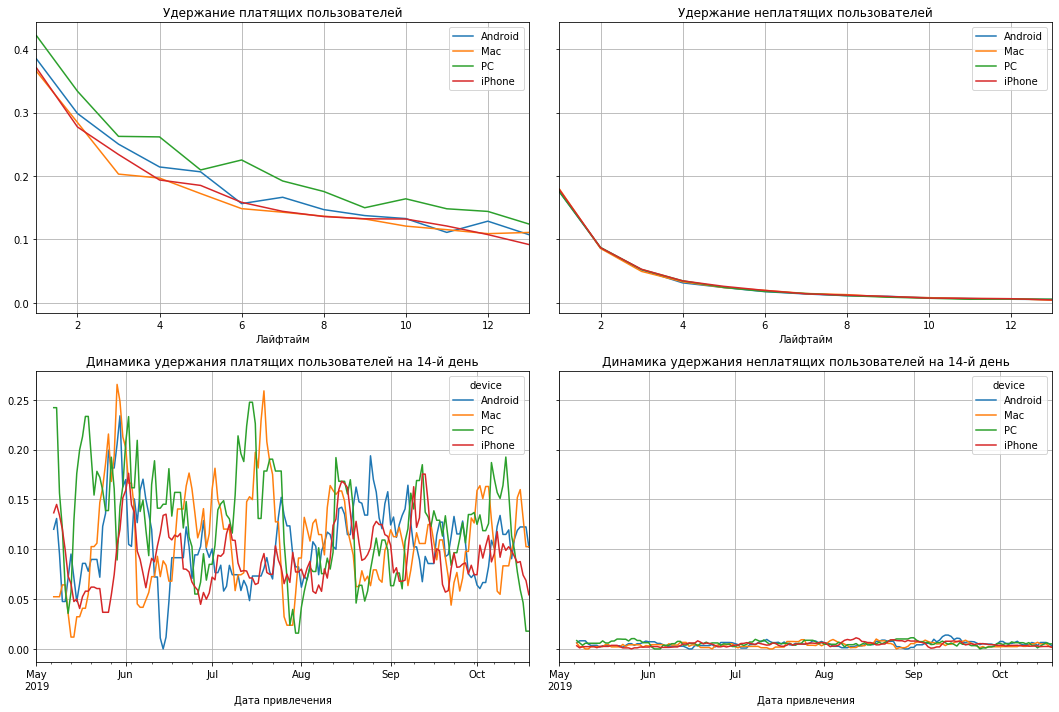

In [49]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи MAC м IPhone показывают самую высокую конверсию, но при этом хуже всех удерживаются.  
А пользователи РС, наоборот, лучше всех удерживаются, но имеют самую низкую конверсию в покупки.

## Анализ окупаемости рекламы с разбивкой по странам

Проанализируем окупаемость рекламы с разбивкой по регионам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

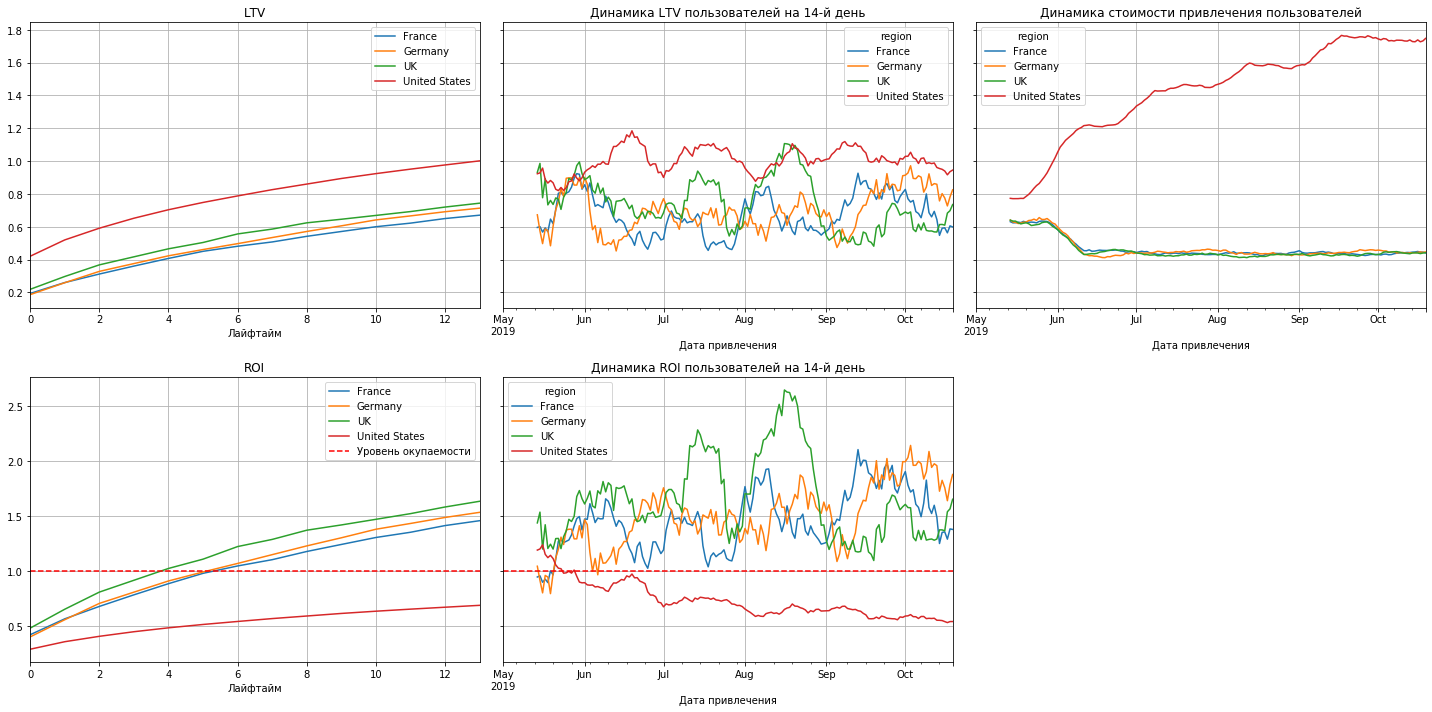

In [50]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

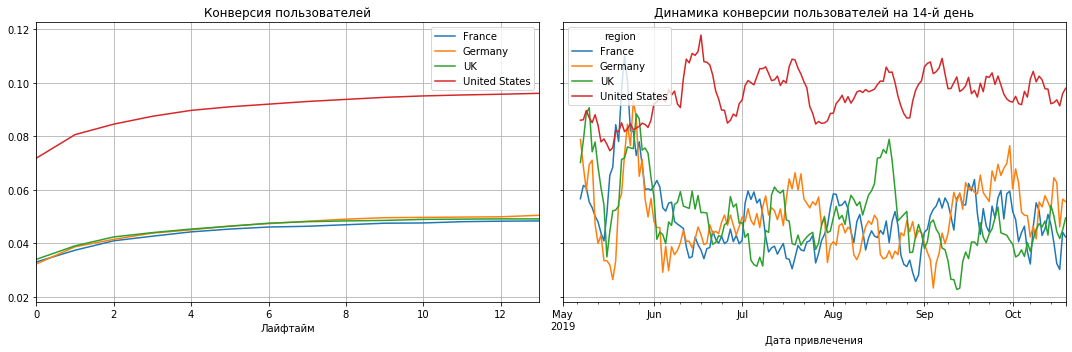

In [51]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
    )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

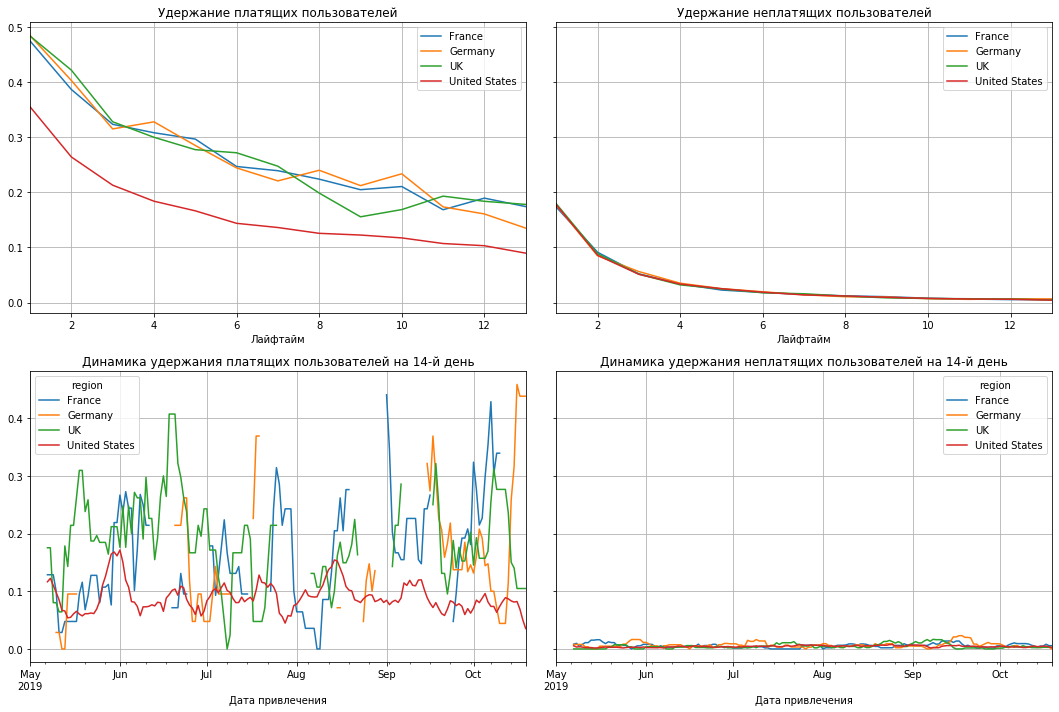

In [52]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Особенно выделяются пользователи из США. Они приносят больше всего денег, лучше всех конвертируются в покупки, но стоимость их привлечения в несколько раз выше, чем пользователей из стран Европы. Да ещё и самый низкий показатель удержания тоже у них.   
Соответственно, ROI пользователи из США самый низкий. Причем отрицательный ROI как на протяжении 14 дневного жизненного цикла, так и в динамике за весь исследуемый период.  
Пользователи из Европы показывают примерно одинаковые результаты по всем параметрам, но самыми эффективными для нас являются пользователи из Великобритании, дающие положительный ROI уже на 5 день жизни.

## Анализ окупаемости рекламы с разбивкой по рекламным каналам

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.  
Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

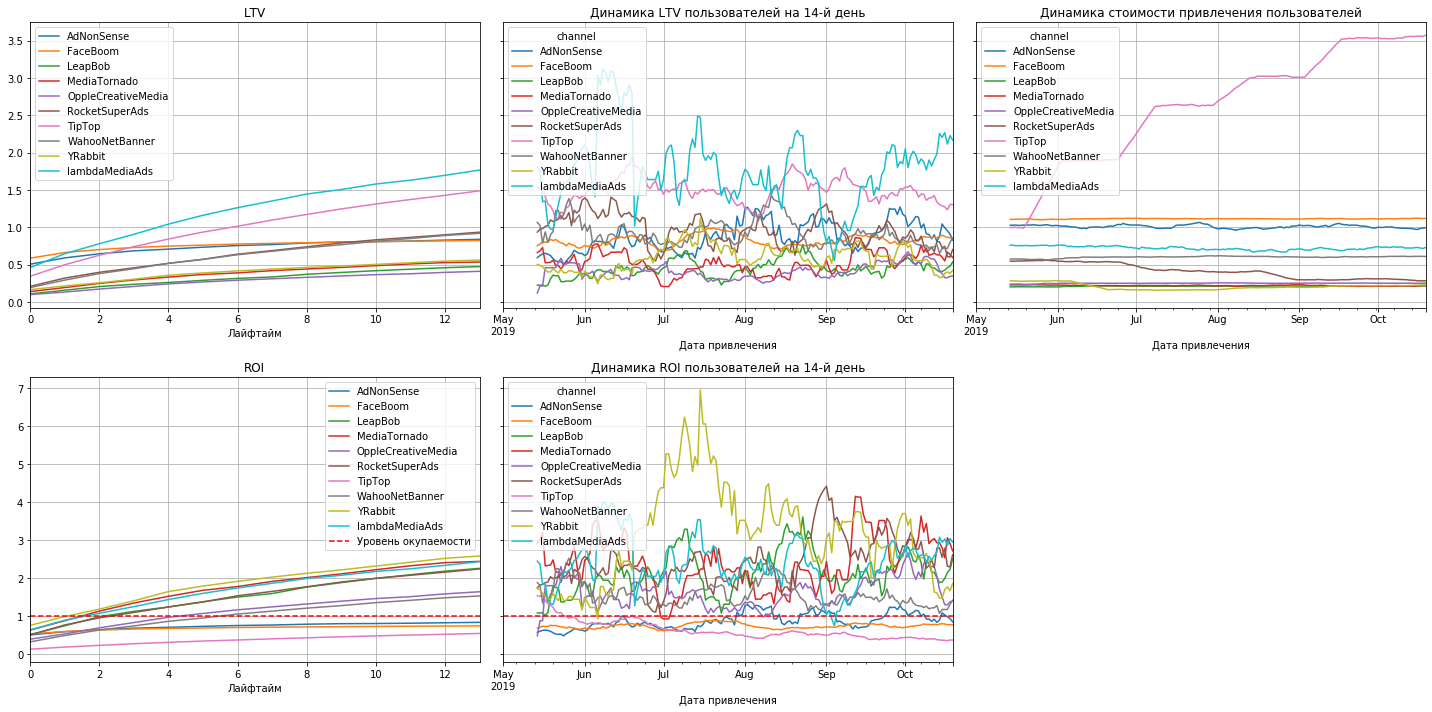

In [53]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
    
) 

Среди источников окупаемости быстрее всего достигают YRabbit, MediaTornado, lambdaMediaAds уже на 2й-3й день жизненного цикла.  
Не достигают окупаемсти за 14 дней такие каналы, как AdNonSense, FaceBoom и TipTop. FaceBoom и TipTop вообще не показывали положительной окупаемости >1 за всю историю наблюдений.  
Хотя именно они приносят практически самые большие продажи. Но из-за высокой стоимости привлечения по факту становятся неэффективными.  

У канала lambdaMediaAds самые ээфективные показатели окупаемости. Самый высокий уровень LTV и один из высоких ROI. Если бы в сентябре у этого канала не было провала по покумкам, то его показатели были бы еще выше.  
А вот у TipTop слишком большие траты (во много раз превышающие все остальные канала) на привлечение, поэтому при высоком LTV он имеет самый низкий ROI.

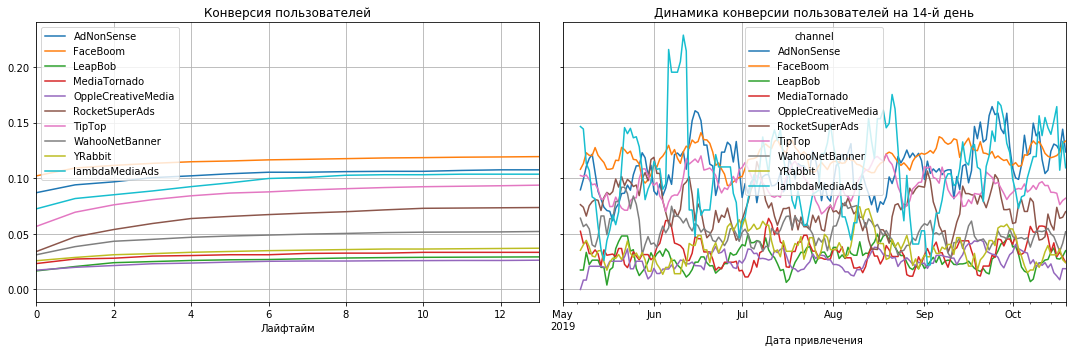

In [54]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
    )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

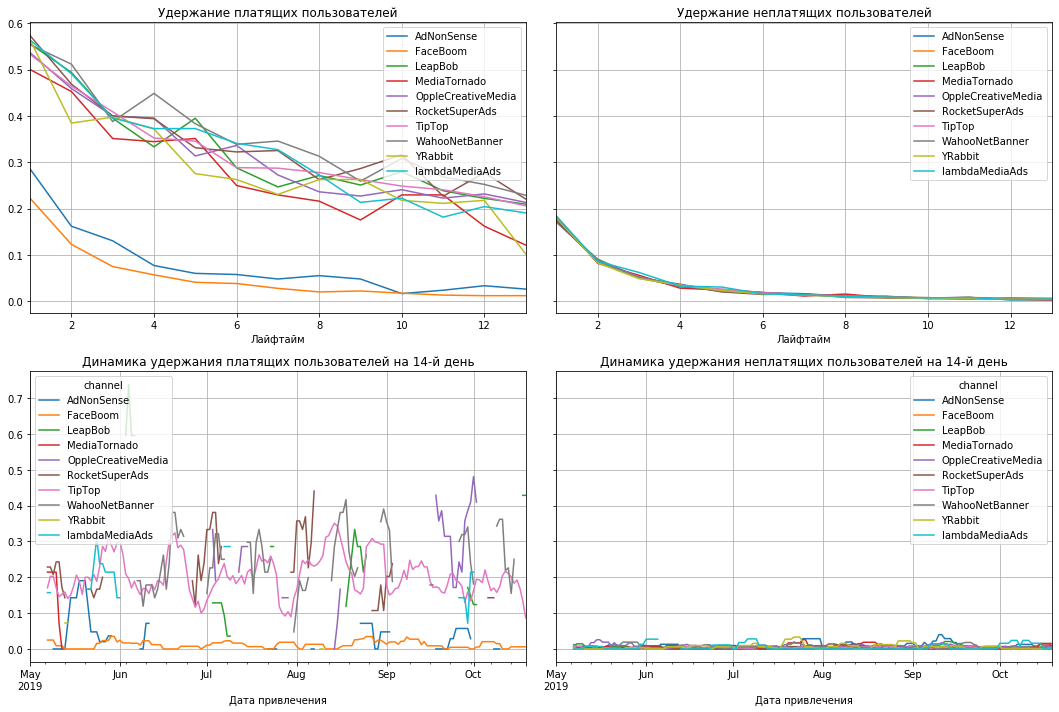

In [55]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Каналы AdNonSense, FaceBoom имеют как самую высокую конверсию в покупки, так и самые низкие показатели удержания пользователей.

# Результаты исследования
- Выделим причины неэффективности привлечения пользователей;
- Сформируем рекомендации для отдела маркетинга для повышения эффективности.

## Выводы

Из графиков видно, что общий ROI не достигает уровня 1, а значит реклама в целом не окупается.

Негативное влияние на окупаемость рекламы оказывают большие траты на пользователей MAC и IPhone, пользователей из Америки и пользователей привлеченных с таких каналов, как TipTop и FaceBoom.

Проблемы окупаемости могут быть связаны:
- с крайне низким показателем удержания пользователей с каналов AdNonSense, FaceBoom. Эти каналы имеют самые высокие показатели конверсии, но при этом обходятся довольно дорого и показывают самые низкие значения ROI.   
- с крайне высокой стоимостью привлечения пользователей с канала TipTop и не самой высокой их конверсией. 
- с низким показателем удержания пользователей из США, котрые обходятся нам максимально дорого, но при этом приносят максимум продаж и имеют самую высокую конверсию
- с высокой стоимостью привлечения пользователей MAC м IPhone


## Рекомендации

Для повышения эффективности стоит проработать:
- варианты снижения стоимости привлечения с каналов AdNonSense, FaceBoom и увеличения показателя удержания для данных пользователей
- варианты снижения стоимости привлечения пользователей с канала TipTop и увеличения конверсии
- возможности уменьшения стоимости привлечения пользователей MAC м IPhone и улучшением показателя их удержания
- варианты стимулирования к покупкам пользователей PC
- возможности уменьшения стоимости привлечения пользователей из США и улучшением показателя их удержания
